## Pneumonia Detection from Chest X-Ray Images

The notebook presents a Convolutional Neural Network (CNN) classifier that detects pneumonia on x-ray images. It also contains a visualization of representations learned by the network using **activation maps** technique. And finally, it features a visual explanation of the classifier results with **Grad-CAM** (Gradient-weighted Class Activation Mapping). Refer to the **[Overview](#Overview-of-Data,-Training,-Model-Results)** section for model performance summary. 


The CNN is a **VGG model** pre-trained on ImageNet dataset and **fine-tuned** on [NIH Chest X-ray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) found on [Kaggle](https://www.kaggle.com/nih-chest-xrays/data). Since the NIH dataset is severely imbalanced (only 1% of all images are classified as pneumonia positive), the **oversampling** of positive class and **undersampling** of negative class were performed prior to training. The final model architecture consists of a VGG architecture, global pooling, fully connected and dropout layers. Adam optimizer was used to improve the binary accuracy, and the final model artifacts were chosen with regard to the best validation loss. 


#### Table of Content:
* [Why Detect Pneumonia?](#Why-Detect-Pneumonia?)
* [**Overview of Data, Training, Model Results**](#Overview-of-Data,-Training,-Model-Results)
* [Load the dataset](#Load-the-dataset)
* [Original Class Distribution](#Original-Class-Distribution)
* [Data Resampling](#Data-Resampling)
    - [Training Set](#Training-Set)
    - [Validation and Test Set](#Validation-and-Test-Set)
* [Data Augmentation and Normalization](#Data-Augmentation-and-Normalization)
* [Modelling & Training](#Modelling-&-Training)
* [Visualization of Learned Patterns](#Visualization-of-Learned-Patterns)
* [Visualization of Intermediate Activation Maps](#Visualization-of-Intermediate-Activation-Maps)
* [Training Performance](#Training-Performance)
* [Metrics Analysis](#Metrics-Analysis)
    - [Precision and Recall](#Precision-and-Recall)
    - [ROC/AUC](#ROC/AUC)
    - [F1-Score](#F1-Score)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Final Classification Report](#Final-Classification-Report)
* [Visual Interpretation of Model Predictions](#Visual-Interpretation-of-Model-Predictions)
* [Acknowledgements](#Acknowledgements)


### Why Detect Pneumonia?

_Pneumonia is a form of acute respiratory infection that is most commonly caused by viruses or bacteria. It can cause mild to life-threatening illness in people of all ages, however it is the single largest infectious cause of death in children worldwide. Pneumonia killed more than 808 000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years. People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems._ [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1)


_With approximately 2 billion procedures per year, chest X-rays are the most common imaging examination tool used in practice, critical for screening, diagnosis, and management of diseases including pneumonia. However, an estimated two thirds of the global population lacks access to radiology diagnostics._ [Stanford ML Group](
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7345724/)


### Overview of Data, Training, Model Results


```
Dataset                    :  NIH Chest X-ray Dataset
Training set               :  3720 (oversampled) positive  & 3720 (undersampled) negative images 
Validation set             :  250 positive & 1002 (undersampled) negative images
Test set                   :  251 positive & 1002 (undersampled) negative images
Train/Val/Test Split       :  ~75/13/13

Test F1-score              :  0.47
Test AUC                   :  0.58
Test Recall                :  0.55
Test Precision             :  0.41
Test Accuracy              :  0.77
Threshold                  :  0.58

Training Loss              :  0.41
Training Accuracy          :  0.73
Training Precision         :  0.67
Training Recall            :  0.79
Training AUC               :  0.80

Validation Loss            :  0.28
Validation Accuracy        :  0.73
Validation Precision       :  0.68
Validation Recall          :  0.79
Validation AUC             :  0.80
```

###  Load the dataset 

In [2]:
# Import necessary dependencies
import numpy as np
import pandas as pd 
import os
from glob import glob
import random
from skimage.transform import resize 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample

import tensorflow as tf 

# Optional pandas configuration for better dataframe readibility
pd.set_option("display.max_columns", None)

Using TensorFlow backend.


In [3]:
df = pd.read_csv('/data/Data_Entry_2017.csv')
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Images found:', len(image_paths))
df['path'] = df['Image Index'].map(image_paths.get)
df.sample(3)

Images found: 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
79248  00019451_000.png     No Finding            0       19451           47   
64452  00015909_001.png     No Finding            1       15909           33   
43810  00011291_000.png     No Finding            0       11291           31   

      Patient Gender View Position  OriginalImage[Width  Height]  \
79248              F            PA                 2742     2589   
64452              F            PA                 2992     2991   
43810              M            PA                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
79248                        0.143  0.143          NaN   
64452                        0.143  0.143          NaN   
43810                        0.168  0.168          NaN   

                                           path  
79248  /data/images_009/images/00019451_000.png  
64452  /data/images_007/images/00015909_001.png  
43810  /data/images_005/images/00011291_000.png

In [4]:
# Create a binary target column
df["Pneumonia"] = df["Finding Labels"].map(lambda x: 1. if "Pneumonia" in x else 0)

In [5]:
df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0                        0.143  0.143          NaN   
1                        0.143  0.143          NaN   
2                        0.168  0.168          NaN   
3                        0.171  0.171          NaN   
4                        0.143  0.143          NaN   

                                       path  Pneumonia  
0  /data/images_001/images/00000001_000.png        0.0  
1  /data/images_001/images/00000001_001.png        0.0  
2  /data/images_001/images/00000001_002.png        0.0  
3  /data/images_001/images/00000002_000.png        0.0  
4  /data/images_001/images/00000003_000.png        0.0

### Original Class Distribution

In [6]:
# Original class distribution 
df["Pneumonia"].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

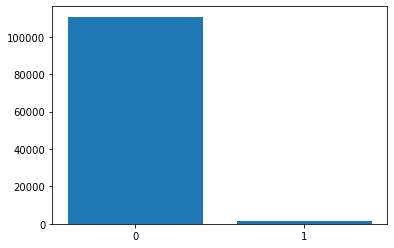

In [7]:
original_neg = df["Pneumonia"].value_counts()[0]
original_pos = df["Pneumonia"].value_counts()[1]
plt.bar([0, 1], [original_neg, original_pos])
plt.xticks(ticks=[0,1])
plt.show()

In [8]:
def create_splits(df, test_size=0.2):
    
    train_data, val_test_data = train_test_split(df, stratify=df.Pneumonia, test_size=test_size, shuffle=True, random_state=1000)
    
    return train_data, val_test_data

In [9]:
# Create initial splits
initial_train_data, initial_val_test_data = create_splits(df, test_size=0.35)

### Data Resampling 

#### Training Set 

In [10]:
# Initial train set distribution
initial_train_data["Pneumonia"].value_counts()

0.0    71948
1.0      930
Name: Pneumonia, dtype: int64

In [11]:
# Over-sample the positive class to obtain 4 times more
train_pos_resampled = resample(initial_train_data[initial_train_data["Pneumonia"] == 1], 
                              n_samples= len(initial_train_data[initial_train_data["Pneumonia"] == 1]) * 3,
                              random_state=1000)  

In [12]:
train_data = pd.concat([initial_train_data, train_pos_resampled])

In [13]:
# Under-sample the negative class to obtain 50/50 class ratio
train_neg_resampled = resample(train_data[train_data["Pneumonia"] == 0],
                               n_samples=train_data[train_data["Pneumonia"] == 1].shape[0],
                               random_state=1000)  

In [14]:
train_data = pd.concat((train_data[train_data["Pneumonia"] == 1], train_neg_resampled))

In [15]:
print(f'Training data: \n{train_data["Pneumonia"].value_counts()}')

Training data: 
0.0    3720
1.0    3720
Name: Pneumonia, dtype: int64


#### Validation and Test Set 

In [16]:
# Initial val + test set distrobution
initial_val_test_data["Pneumonia"].value_counts()

0.0    38741
1.0      501
Name: Pneumonia, dtype: int64

Under-sample negative class to obtain 80/20 class ratio

In [17]:
# Under-sample the negative class to obtain 80/20 class ratio
val_test_neg_resampled = resample(initial_val_test_data[initial_val_test_data["Pneumonia"] == 0], 
                                  n_samples=initial_val_test_data[initial_val_test_data["Pneumonia"] == 1].shape[0] * 4 , 
                                  random_state=1000)

In [18]:
val_test_data = pd.concat((initial_val_test_data[initial_val_test_data["Pneumonia"] == 1], val_test_neg_resampled))

In [19]:
val_data, test_data = create_splits(val_test_data, test_size=0.5)

In [20]:
print(f'Validation data: \n{val_data["Pneumonia"].value_counts()}') 

Validation data: 
0.0    1002
1.0     250
Name: Pneumonia, dtype: int64


In [21]:
print(f'Testing data: \n{test_data["Pneumonia"].value_counts()}')

Testing data: 
0.0    1002
1.0     251
Name: Pneumonia, dtype: int64


Train/val/test ratio:       75/13/13


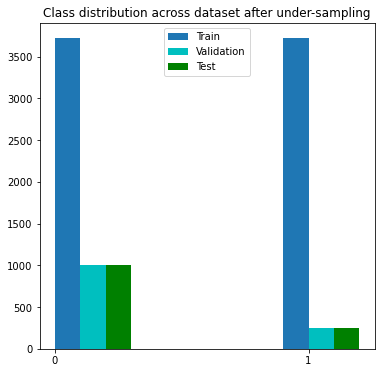

In [22]:
# Show final class distribution across all sets
plt.figure(figsize=(6,6))
plt.hist(train_data["Pneumonia"], label="Train")
plt.hist(val_data["Pneumonia"]+0.1, label="Validation", color='c') # +0.1 for visibility on the plot
plt.hist(test_data["Pneumonia"]+0.2, label="Test", color='g') 
plt.xticks(ticks=[0,1])
plt.legend(loc="upper center")
plt.title("Class distribution across dataset after under-sampling")

all_data = len(train_data) + len(val_data) + len(test_data)
print(f'Train/val/test ratio: \
      {100*len(train_data)/all_data:.0f}/{100*len(val_data)/all_data:.0f}/{100*len(test_data)/all_data:.0f}')
plt.show()

### Data Augmentation and Normalization

In [23]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest',
                              brightness_range=[0.9,1.1])

In [24]:
val_test_idg = ImageDataGenerator(rescale=1. / 255.)

In [25]:
train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                     directory=None, 
                                     x_col = 'path',
                                     y_col = 'Pneumonia',
                                     class_mode = 'raw',
                                     target_size = (224, 224), 
                                     batch_size = 64, 
                                     seed=1000)

Found 7440 validated image filenames.


In [26]:
val_gen = val_test_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'raw',
                                         target_size = (224, 224), 
                                         batch_size = 64,
                                         seed=1000)

Found 1252 validated image filenames.


In [27]:
test_gen = val_test_idg.flow_from_dataframe(dataframe=test_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'raw',
                                         target_size = (224, 224), 
                                         batch_size = 465,
                                         seed=1000)

Found 1253 validated image filenames.


In [28]:
testX, testY = test_gen.next()

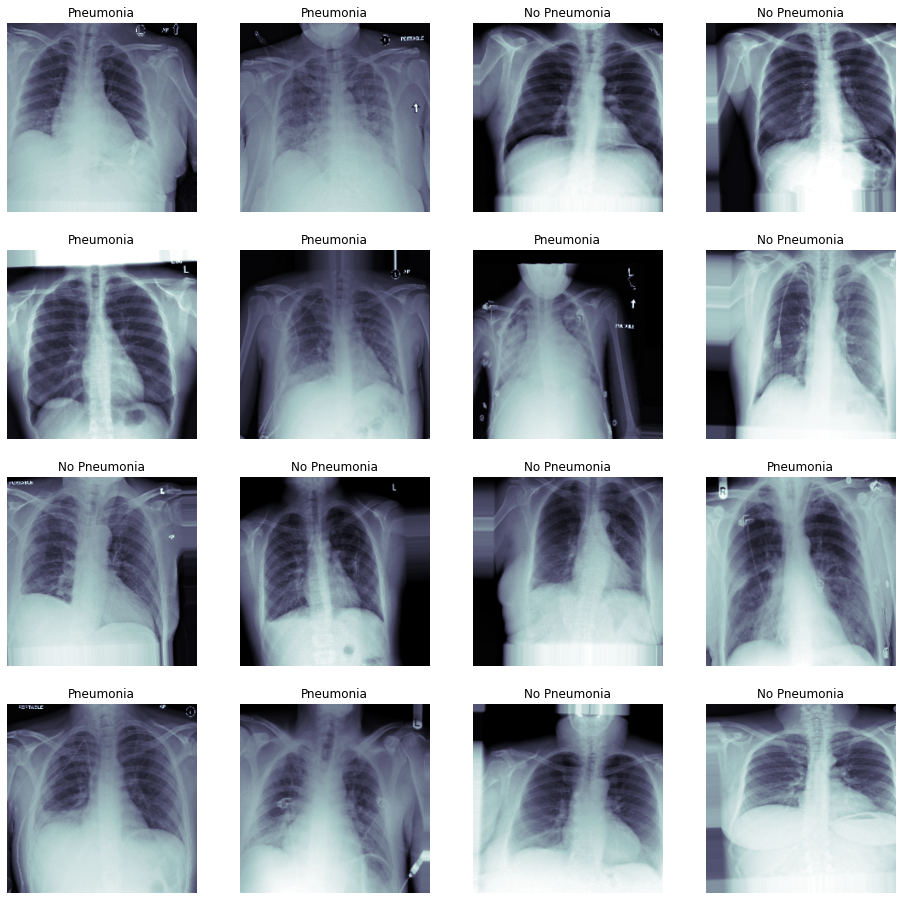

In [29]:
# Glimpse at the augmented data 
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

### Modelling & Training

In [30]:
# Load pretrained VGG and freeze all but the last convolutional layer

def load_pretrained_model():
    
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    for layer in vgg_model.layers:
        if layer.name == "block5_conv3":
            layer.trainable = True
        else:
            layer.trainable = False
        
    return vgg_model

In [31]:
vgg_model = load_pretrained_model()

58892288/58889256 [==============================] - 1s 0us/step


In [32]:
# vgg_model.summary()

In [37]:
def build_model(vgg_model, units=[128], dropout=0.2):
    
    x = GlobalAveragePooling2D()(vgg_model.output)
    
    for i in range(len(units)):
        x = Dense(units[i], activation="relu", name='fc'+str(i+1))(x)
        x = Dropout(dropout)(x)
        
    x = Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs= vgg_model.input, outputs=x)
    
    optimizer = Adam(lr=3e-3)
    loss = 'binary_crossentropy'
    
    metrics = [tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall'),
               tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')]
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [38]:
model = build_model(vgg_model, units=[512, 256, 128], dropout=0.5)

In [40]:
checkpoint = ModelCheckpoint("model.best.h5",  # "model.{epoch:02d}-{val_loss:.2f}.h5"
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=4, 
                              verbose=1, 
                              mode='min', 
                              cooldown=5,
                              min_lr=0.0001)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=30)

callbacks_list = [checkpoint, early, lr_reduce]

In [35]:
history = model.fit_generator(train_gen, 
                              validation_data = val_gen, 
                              epochs = 30,
                              callbacks = callbacks_list)

Epoch 1/30
117/117 [==============================] - 229s 2s/step - loss: 0.7526 - precision: 0.5155 - recall: 0.5245 - auc: 0.5162 - binary_accuracy: 0.5146 - val_loss: 0.6434 - val_precision: 0.5256 - val_recall: 0.5718 - val_auc: 0.5634 - val_binary_accuracy: 0.5502

Epoch 00001: val_loss improved from inf to 0.64339, saving model to model.best.h5
Epoch 2/30
117/117 [==============================] - 210s 2s/step - loss: 0.6584 - precision: 0.5469 - recall: 0.5699 - auc: 0.6004 - binary_accuracy: 0.5782 - val_loss: 0.5259 - val_precision: 0.5633 - val_recall: 0.5859 - val_auc: 0.6242 - val_binary_accuracy: 0.5954

Epoch 00002: val_loss improved from 0.64339 to 0.52593, saving model to model.best.h5
Epoch 3/30
117/117 [==============================] - 213s 2s/step - loss: 0.6411 - precision: 0.5723 - recall: 0.6020 - auc: 0.6414 - binary_accuracy: 0.6067 - val_loss: 0.6341 - val_precision: 0.5745 - val_recall: 0.6210 - val_auc: 0.6495 - val_binary_accuracy: 0.6120

Epoch 00003: val

In [42]:
model.load_weights('model.best.h5') 

###  Visualization of Learned Patterns
Image **patterns** (weights with 2D spatial relationships) learned by the model.

In [43]:
for i, layer in enumerate(model.layers):
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(i, layer.name, filters.shape)

1 block1_conv1 (3, 3, 3, 64)
2 block1_conv2 (3, 3, 64, 64)
4 block2_conv1 (3, 3, 64, 128)
5 block2_conv2 (3, 3, 128, 128)
7 block3_conv1 (3, 3, 128, 256)
8 block3_conv2 (3, 3, 256, 256)
9 block3_conv3 (3, 3, 256, 256)
11 block4_conv1 (3, 3, 256, 512)
12 block4_conv2 (3, 3, 512, 512)
13 block4_conv3 (3, 3, 512, 512)
15 block5_conv1 (3, 3, 512, 512)
16 block5_conv2 (3, 3, 512, 512)
17 block5_conv3 (3, 3, 512, 512)


**Tensor dimensions**: filter size x filter size x filter depth x number of filters = (depth of a the input)

In [44]:
# Retrieve weights from the second hidden layer = the first convolutional layer
filters, biases = model.layers[1].get_weights()

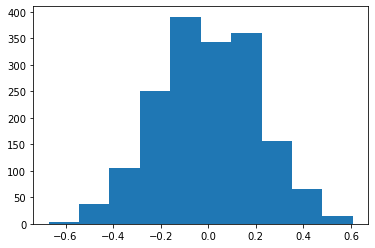

In [45]:
plt.hist(filters.flatten())
plt.show()

In [46]:
# Normalize filter values to 0-1 for visualization (outputs are small positive and negative values centered around 0)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

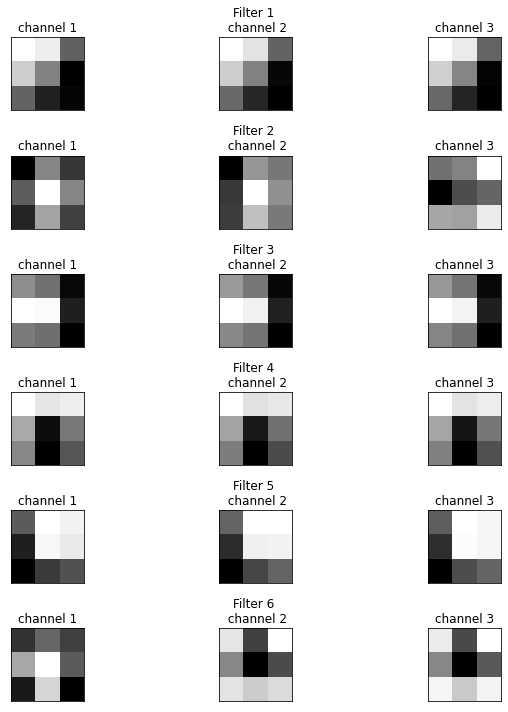

In [47]:
# Plot first few filters
n_filters, ix = 6, 1

plt.figure(figsize=(10,10))

for i in range(n_filters):
    
    # Get the filter
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):
        
        # Specify subplot and turn off axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Set subplot title
        if j == 1:
            ax.set_title(f'Filter {i+1} \n channel {j+1}')
        else:
            ax.set_title(f'channel {j+1}')
            
        # Plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1

# Show the figure
plt.tight_layout()

White spots indicate large (excitatory) weights.

Black spots indicate small (inhibitory) weights.

### Visualization of Intermediate Activation Maps
What features of the input are preserved in the activation (feature) maps.

In [48]:
testY[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1.])

Label : 0


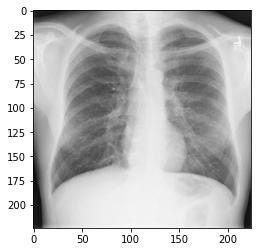

In [49]:
# Choose an image (pneumonia positive)
x = np.expand_dims(testX[7], axis=0)
plt.imshow(x[0], cmap='bone')
print("Label :", int(testY[13]))
plt.show()

In [50]:
# Summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    
    # Check for convolutional layer
    if 'conv' not in layer.name:
        continue
        
    # Summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [51]:
# Take the output of the last convolutional layer from each block
conv_blocks = [2, 5, 9, 13, 17]  
layer_names = [model.layers[i].name for i in conv_blocks]
conv_blocks_outputs = [model.layers[i+1].output for i in conv_blocks]

In [52]:
# Define a model to output activations from selected layers
activation_model = Model(inputs=model.inputs, outputs=conv_blocks_outputs)

In [53]:
# Make predictions on selected image
activations = activation_model.predict(x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


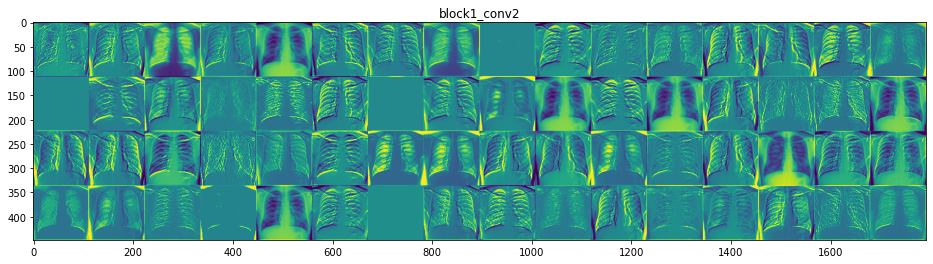

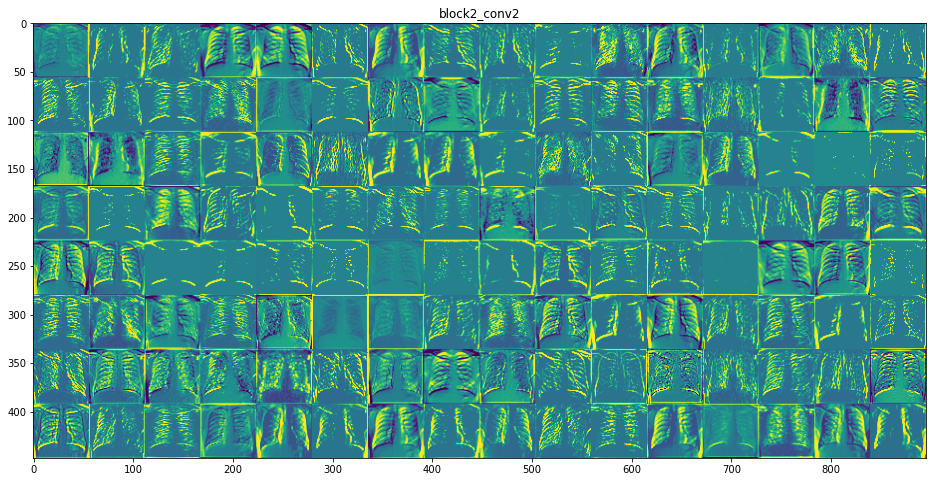

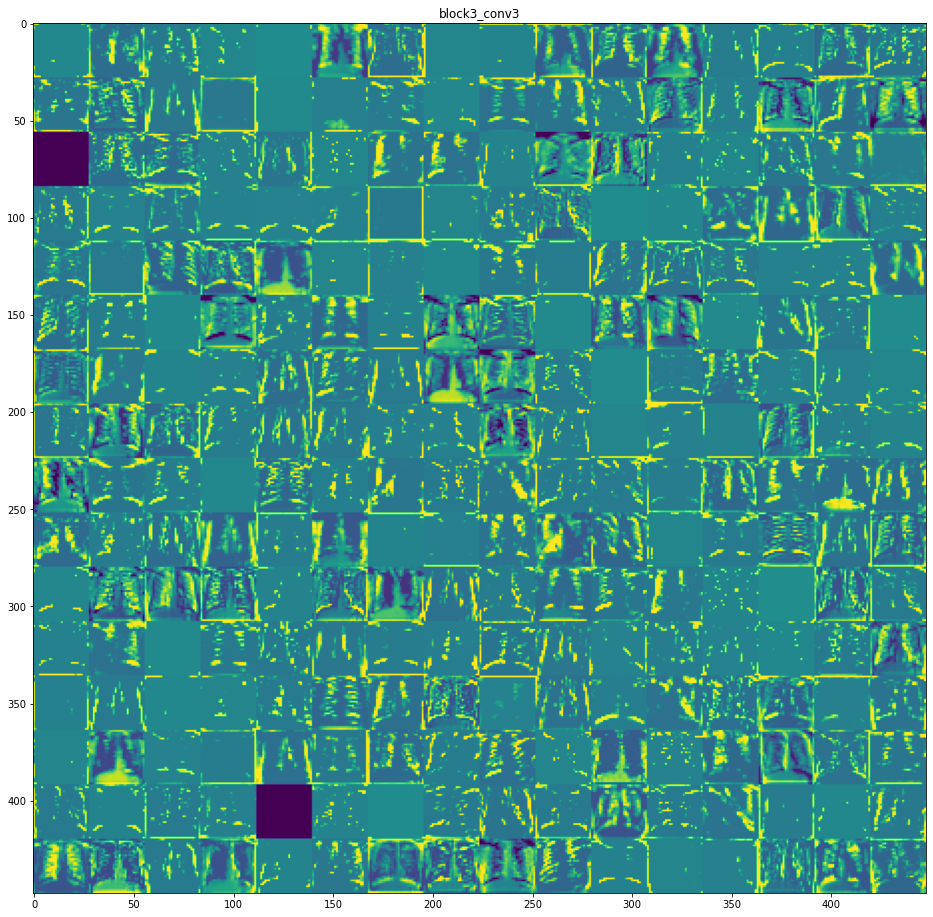

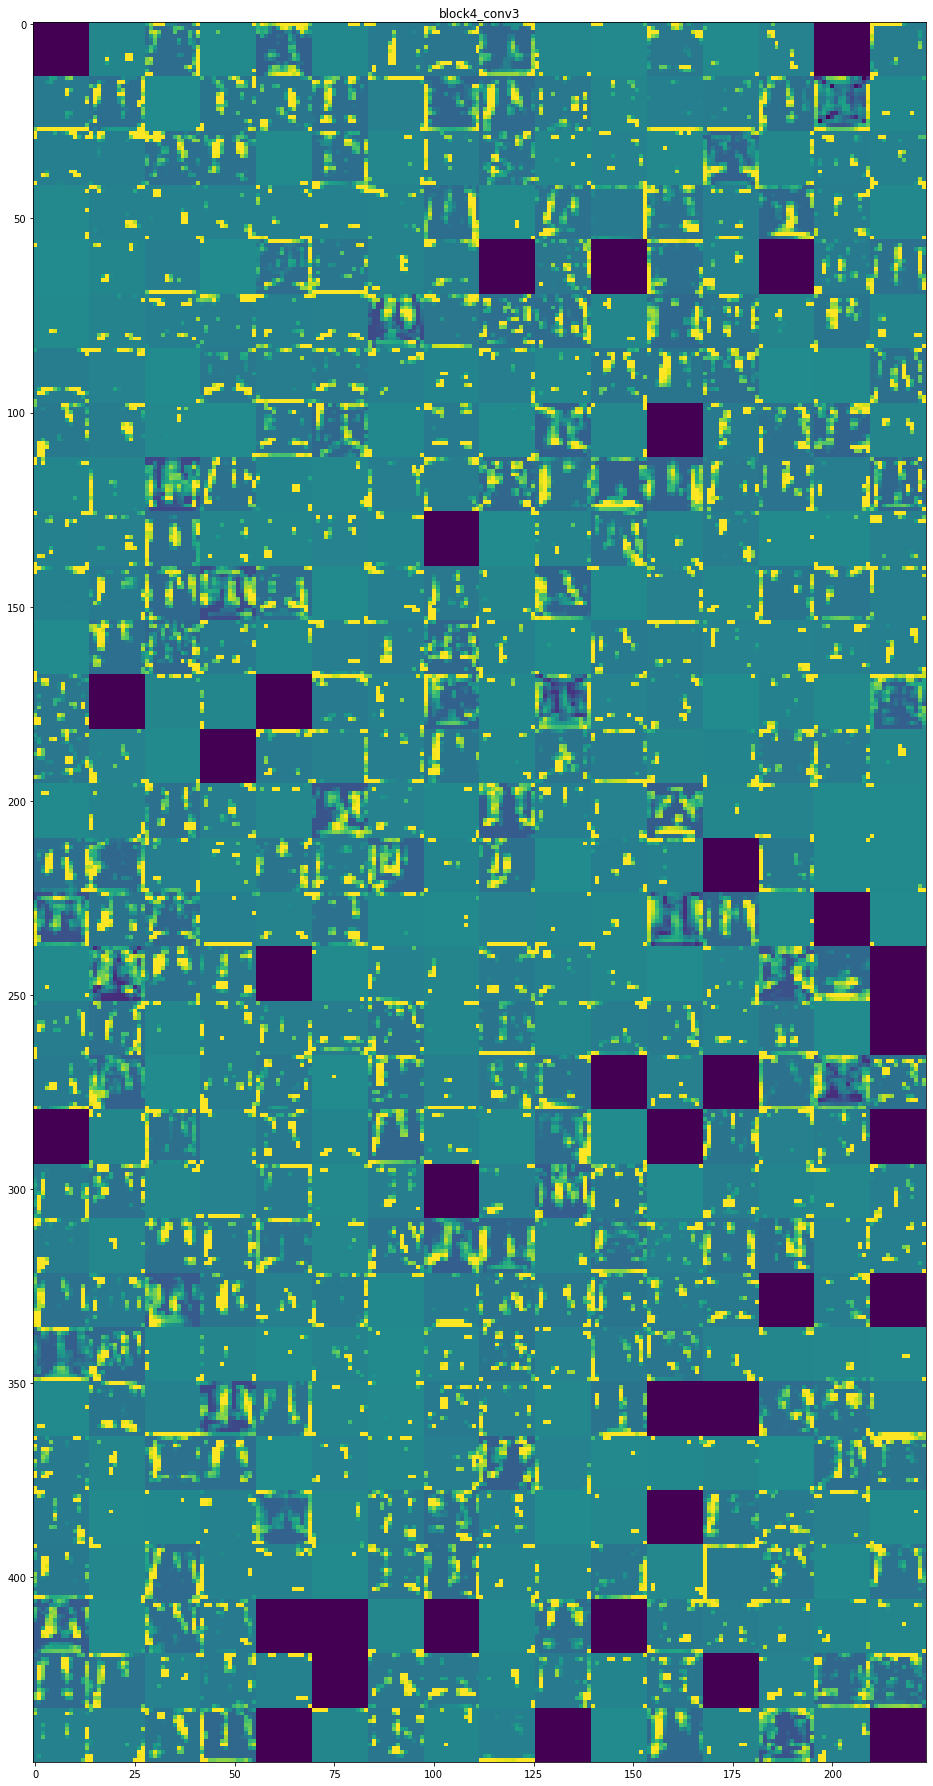

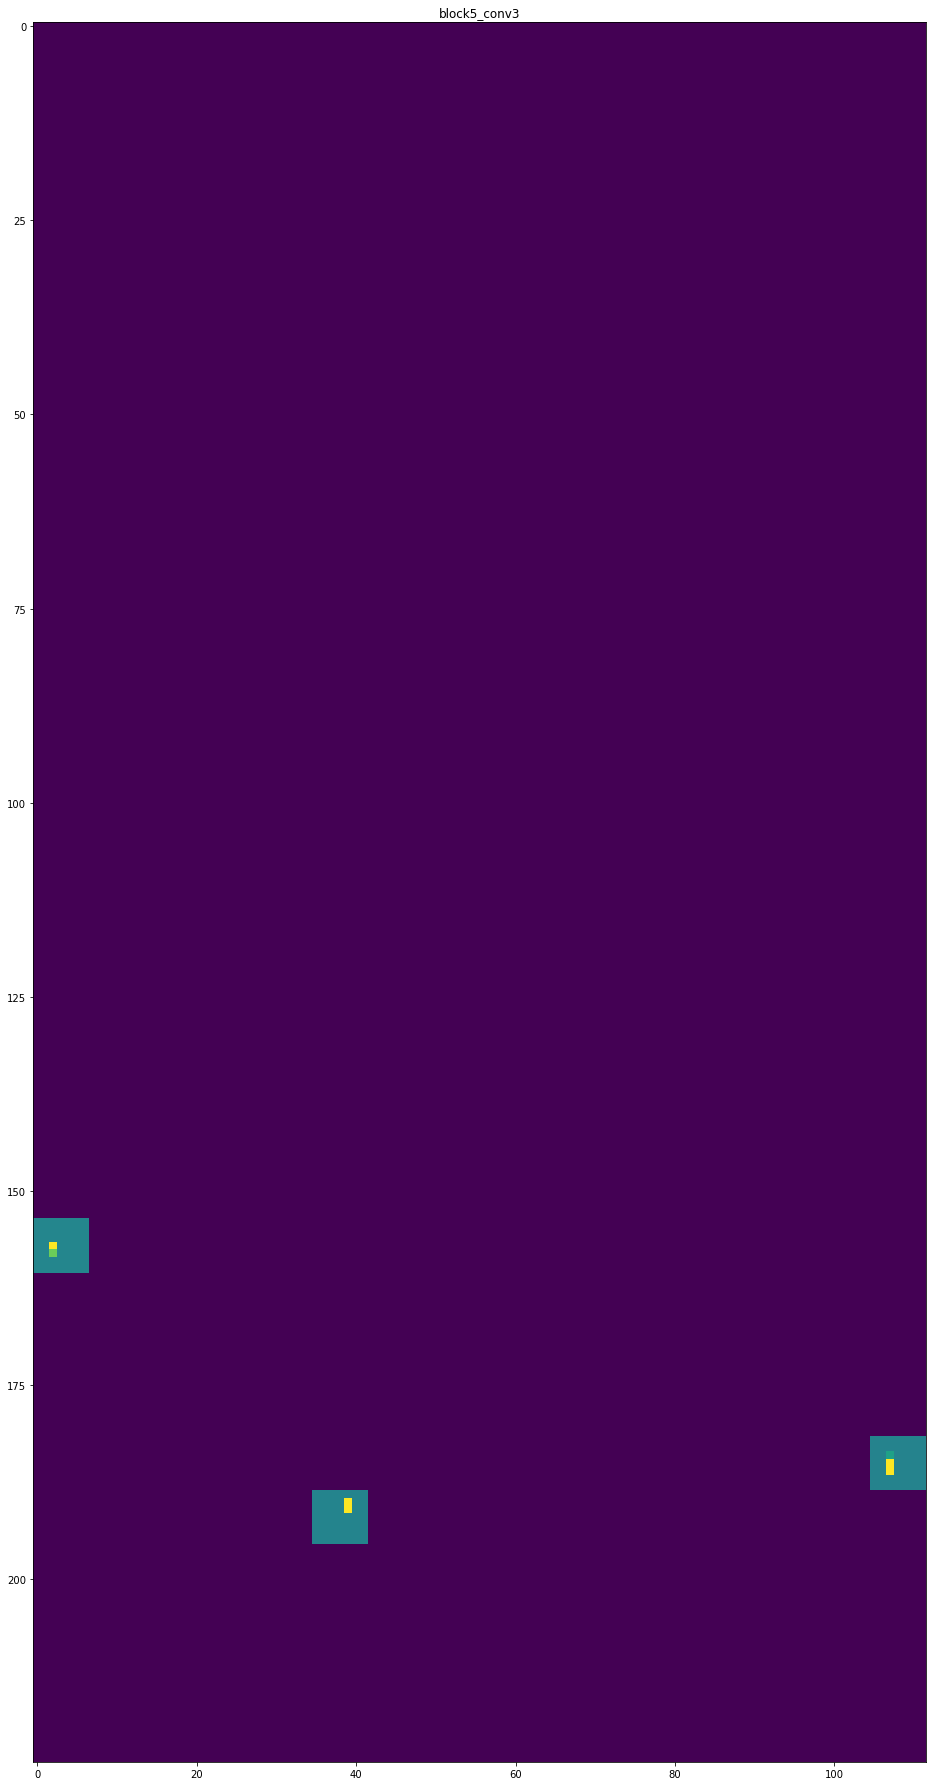

In [54]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps

    # Number of features (filters) in the feature map 
    n_features = layer_activation.shape[-1] 

    # The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1] 

    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tiles each filter into a big horizontal grid
    for col in range(n_cols): 
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]

            # Post-processes the feature for a better visual effect
            channel_image -= channel_image.mean() 
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size

    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Training Performance

In [57]:
def plot_history(hist):
    
    hist = pd.DataFrame(data=history.history)
    
    # Plot cost function
    hist.iloc[:,[0,5]].plot()
    plt.title("Model loss during training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Plot accuracy 
    hist.iloc[:,[4,9]].plot()
    plt.title("Model accuracy during training")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    plt.show()

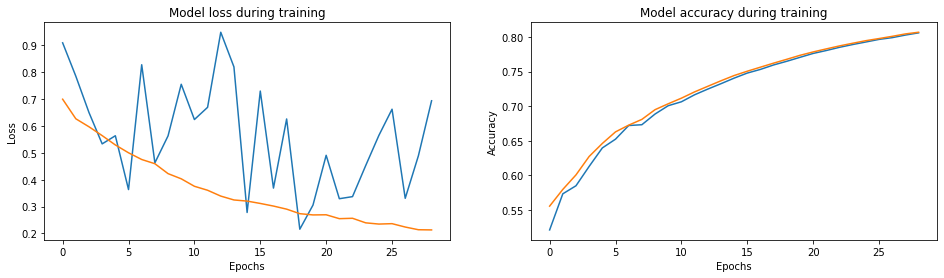

In [6]:
plot_history(history)

### Analysis of Metrics 

In [62]:
y_pred = model.predict(testX, verbose = True)

465/465 [==============================] - 437s 941ms/step


#### Precision and Recall

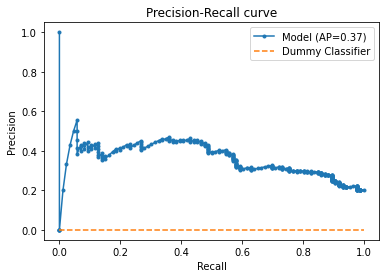

In [63]:
# Plot precision-recall curve (pairs for different thresholds)
precision, recall, thresholds = precision_recall_curve(testY, y_pred)

# Average precision summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold,
# with the increase in recall from the previous threshold used as the weight. 
# This implemetation does not use linear interpolation
avg_precision = average_precision_score(testY, y_pred)

plt.plot(recall, precision, label=f'Model (AP={avg_precision:.2f})', marker='.')
plt.plot([0, 1], [0, 0], linestyle='--', label='Dummy Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall curve")
plt.legend()
plt.show()

#### ROC/AUC

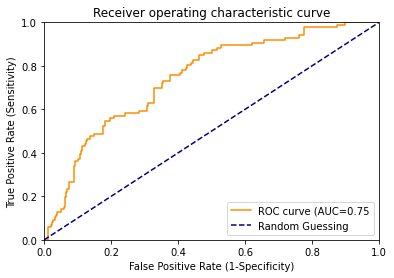

In [64]:
# This implementation uses trapezoidal rule and linear interpolation, sometimes may be too optimistic
    
# Calculate Receiver operating characteristic curve (ROC) (points + thresholds)
fpr, tpr, thresholds = roc_curve(testY, y_pred.ravel(), pos_label=1)

# Calculate are under the curve (AUC)
auc_score = auc(fpr, tpr)

# Plot ROC curve 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC={auc_score:.2f}' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

#### F1-Score

In [65]:
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)

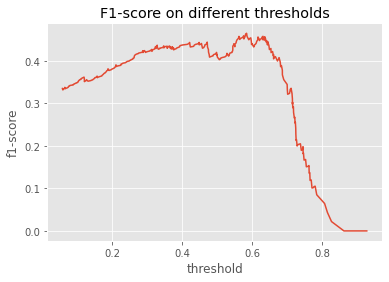

In [66]:
# Plot F1-score on different thresholds
precision, recall, thresholds = precision_recall_curve(testY, y_pred)
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(thresholds))]

# Choose the threshold that optimizes F1-score
thresh_idx = np.argmax(f1_scores)
thresh = thresholds[thresh_idx]

plt.figure()
plt.style.use("ggplot")
plt.plot(thresholds, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score on different thresholds')
plt.show()

In [67]:
print(f"Threshold = {thresh:.2f}")
print(f"Precision = {precision[thresh_idx]:.2f}")
print(f"Recall = {recall[thresh_idx]:.2f}")
print(f"F1-score {f1_scores[thresh_idx]:.2f}")

Threshold = 0.58
Precision = 0.41
Recall = 0.55
F1-score 0.47


#### Confusion Matrix

In [68]:
# TN FP
# FN TP
confusion_matrix(testY, y_pred > thresh)

array([[310,  69],
       [ 40,  46]])

#### Final Classification Report

In [69]:
print(sklearn.metrics.classification_report(testY, 
                                            [int(i) for i in (y_pred>thresh)], 
                                            target_names = ['No Pneumonia','Pneumonia']))

              precision    recall  f1-score   support

No Pneumonia       0.89      0.82      0.85       379
   Pneumonia       0.40      0.53      0.46        86

    accuracy                           0.77       465
   macro avg       0.64      0.68      0.65       465
weighted avg       0.80      0.77      0.78       465



In [70]:
# Save model architecture
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Visual Interpretation of Model Predictions 

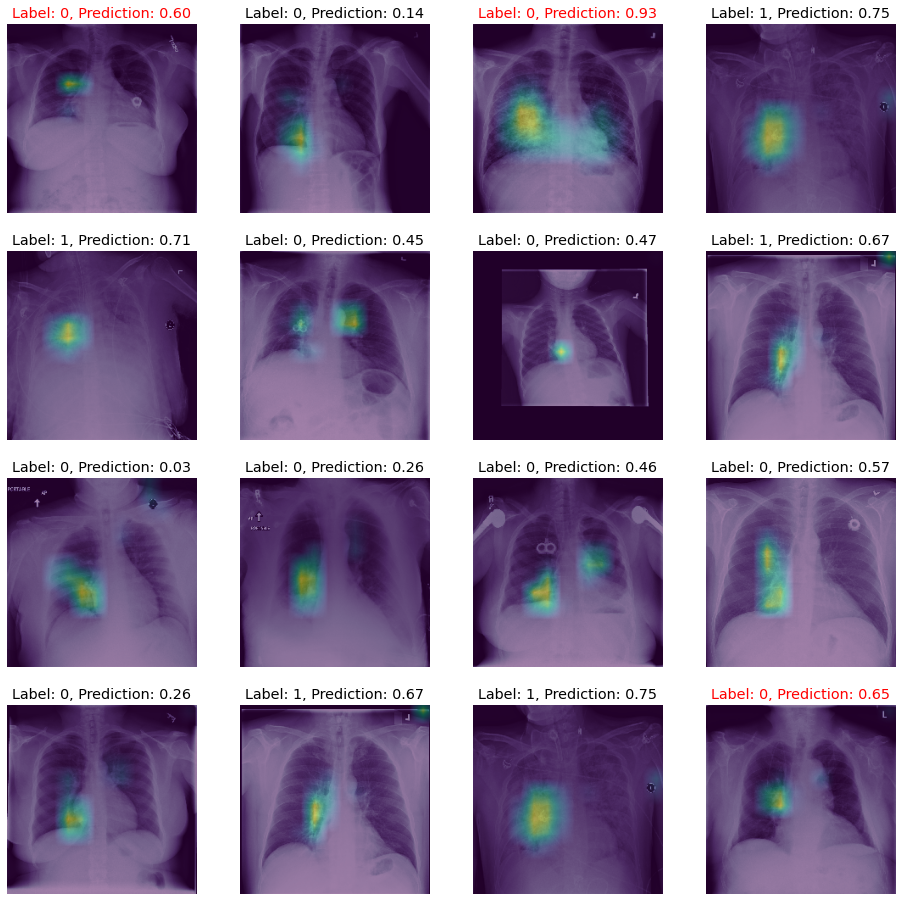

In [71]:
fig, m_axs = plt.subplots(4, 4,  figsize=(16, 16))

random_indexes = [random.randint(0, len(testX)) for i in range(16)]

for index, ax in zip(random_indexes, m_axs.flatten()):
    
    # Image description 
    prediction = y_pred[index][0]
    
    if (prediction > thresh) == bool(testY[index]):
        color = 'k'
    else:
        color = 'r'
        
    ax.set_title(f'Label: {testY[index]:.0f}, Prediction: {prediction:.2f}', color=color)
    
    # Grad-Cam
    last_conv = model.get_layer('block5_conv3')
    grads = K.gradients(model.output, last_conv.output)[0]
    pooled_grads = K.mean(grads, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_grads, last_conv.output[0]])
    test_preprocessed = np.expand_dims(testX[index] ,axis=0)
    pooled_grads_value, conv_layer_output = iterate([test_preprocessed])

    for i in range(224):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output,axis=-1)

    # Apply ReLU function
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)

    # Standardize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Plot 
    upsample = resize(heatmap, (224, 224), preserve_range=True)
    ax.imshow(testX[index][:,:,0], cmap='bone')
    ax.imshow(upsample, alpha=0.5)
    ax.axis('off')

### Acknowledgements
The visual analysis with activation maps was greatly inspired by [this](https://ming-zhao.github.io/Optimization-and-Learning/html/docs/convnet.html) resource by Ming Zhou.